In [22]:
import pandas as pd
import numpy as np


%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [23]:
# data = pd.DataFrame()

from warnings import filterwarnings
filterwarnings('ignore')

In [24]:
data = pd.read_csv('magic_stompy2018.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

In [49]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', 1)
data.set_value(now, 'life', 2)
data.set_value(now, 'opponents_life', 0)
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', 1)
data.set_value(now, 'land rating', 3)
data.set_value(now, 'archetype', 'rdw')

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'initiates companion', 1)
data.set_value(now, 'llanowar elves', 2)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'old growth dryads', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 2)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'adventurous impulse', 1)
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 0)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 1)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 1)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')

In [50]:
data.mean()

won                        0.507692
life                       8.038462
opponents_life             9.061538
deck_size                 60.000000
starting lands             2.800000
druid of the cowl          0.107692
llanowar elves             0.876923
steel life champion        0.923077
vine mare                  0.907692
blanchwood armor           0.092308
lifecrafters bestiary      0.246154
natures way                0.107692
plummet                    0.200000
rabid bite                 0.507692
titanic growth             0.107692
verdant rebirth            0.169231
gigantosaurus              0.307692
majestic myriarch          0.107692
verdurous gearhulk         0.076923
scaled behemoth            0.076923
ghalta                     0.230769
land rating                3.030769
walking ballista           0.123077
colossal majesty           0.430769
aggressive mamoth          0.000000
rhonas                     0.369231
mouth                      0.000000
blossoming defense         0

In [16]:
# creatures = ['oketra', 'rhonas', 'serpopard', 'pacifist', 'baloth pup', 'mouth', 'croc',
# 'exemplar', 'defiant greatmaw', 'glorybound initiate', 'initiates companion',]

# removal = ['gideons reproach', 'reprisal', 'declare in stone', 'prepare']

# data['creatures_total'] = data[creatures].sum(axis=1)
# data['removal_total'] = data[removal].sum(axis=1)

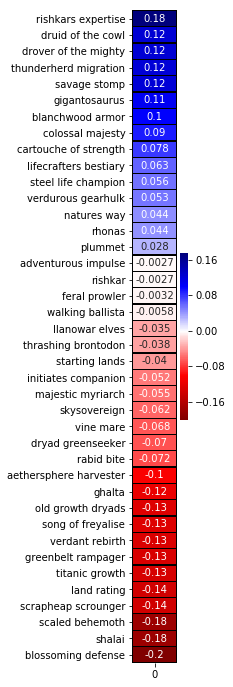

In [51]:
meta_stats = ['won', 'life', 'archetype', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

winning_cards = data[cards].corrwith(data['won'])
winning_cards = pd.DataFrame(winning_cards).dropna().sort_values(0, ascending=False)

plt.figure(figsize=(1,12))

sns.heatmap(winning_cards,
           annot=True, cmap='seismic_r', linecolor='black',
           linewidths=.25, center=0)

In [52]:
from scipy import stats
sleep = []
for i in data.select_dtypes(include=[np.number]).drop(['life', 'opponents_life'], axis=1).columns:
    c = stats.pearsonr(data['won'], data[i])
    if c[1] < .15:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
0,blossoming defense,-0.202467,0.105778


In [42]:
cards = [
    'drover of the mighty',
    'druid of the cowl',
    'feral prowler',
    'dryad greenseeker',
    'greenbelt rampager',
    'initiates companion',
    'llanowar elves',
    'mouth',
    'old growth dryads',
    'rishkar',
    'steel life champion',
    'thrashing brontodon',
    'vine mare',
    'walking ballista',
    'aethersphere harvester',
    'lifecrafters bestiary',
    'skysovereign',
    'scrapheap scrounger',
    'adventurous impulse',
    'blanchwood armor',
    'blossoming defense',
    'cartouche of strength',
    'colossal majesty',
    'natures way',
    'plummet',
    'rabid bite',
    'rishkars expertise',
    'savage stomp',
    'song of freyalise',
    'thunderherd migration',
    'titanic growth',
    'verdant rebirth',
    'vivien reid',
    'aggressive mamoth',
    'ghalta',
    'gigantosaurus',
    'majestic myriarch',
    'rhonas',
    'scaled behemoth',
    'shalai',
    'verdurous gearhulk',
]

In [43]:
combinations = pd.DataFrame()

for i in cards:
    for j in cards:
        if i > j:
            combinations[i + ' + ' + j] = data[i] + data[j]

In [44]:
from scipy import stats
sleep = []
for i in combinations.columns:
    c = stats.pearsonr(data['won'], combinations[i])
    if c[1] < .1:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
20,shalai + scaled behemoth,-0.267552,0.034013
15,scaled behemoth + ghalta,-0.252562,0.045824
5,titanic growth + blossoming defense,-0.250601,0.047593
14,scaled behemoth + blossoming defense,-0.247976,0.050048
9,verdant rebirth + blossoming defense,-0.243130,0.054850
19,shalai + ghalta,-0.235442,0.063233
16,shalai + greenbelt rampager,-0.233314,0.065727
2,scrapheap scrounger + ghalta,-0.228936,0.071108
11,verdant rebirth + shalai,-0.228087,0.072190
7,titanic growth + scaled behemoth,-0.227903,0.072427


In [17]:
# Machine learning

In [36]:
x = data[cards]
y = data['won']

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,21),
    'min_samples_leaf': [1,2,3,4,5,10],
    'min_samples_split': np.arange(2,6),
}

clf = DecisionTreeClassifier()

grid = GridSearchCV(clf, param_grid=param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

print('Mean:', cv.mean())
print('Std dev:', cv.std())

Mean: 0.5539944903581268
Std dev: 0.05337207671722173


# Template

In [ ]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', )
data.set_value(now, 'life', )
data.set_value(now, 'opponents_life', )
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', )
data.set_value(now, 'land rating', )
data.set_value(now, 'archetype', '')

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'initiates companion', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'old growth dryads', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'adventurous impulse', 0)
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 0)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 0)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')